In [1]:
# 繪圖設定字體顏色(否則黑色會看不到)
import matplotlib as mpl
COLOR1 = 'red'
COLOR2 = 'blue'
mpl.rcParams['text.color'] = COLOR1
mpl.rcParams['axes.labelcolor'] = COLOR2
mpl.rcParams['xtick.color'] = COLOR2
mpl.rcParams['ytick.color'] = COLOR2

# YOLOV3 x tensorflow 2.0
    # h5檔案取得：https://github.com/qqwweee/keras-yolo3

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 99.52818155288696
dog 82.25975036621094
cat 78.0703604221344


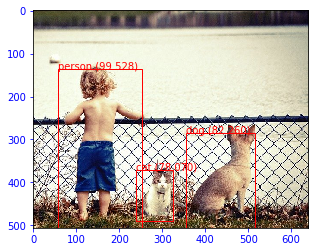

In [2]:
import numpy as np
from numpy import expand_dims
from matplotlib import pyplot
%matplotlib inline
from matplotlib.patches import Rectangle
import tensorflow as tf

# 載入圖片 前處理
def load_image_pixels(filename, shape):
    # 取得原寬高
    image = tf.keras.preprocessing.image.load_img(filename)
    width, height = image.size
    # load + reshape寬高
    image = tf.keras.preprocessing.image.load_img(filename, target_size=shape)
    # convert to numpy array
    image = tf.keras.preprocessing.image.img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

# 轉 0-1 的sigmoid
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

# 自訂函數：框框物件(OOP)
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness=None, classes=None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
    # 類別機率最大值的index
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        return self.label
    # 類別機率最大值
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.score

# 候選邊框解碼
    # 參數：(指定的編碼後預測結果, 框座標錨, threshold, 新高, 新寬)
        # netout shape=(13, 13, 255), (26, 26, 255), (52, 52, 255)
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    # 該種網格 寬高個數
    grid_h, grid_w = netout.shape[:2]
    # 3種邊界框
    nb_box = 3
    # (對應的網格數, 對應的網格數, 3, (5+C))
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    # 類別數量
    nb_class = netout.shape[-1] - 5
    # 除了w, h，其他都取0-1的sigmoid
        # [..., 不管前面有幾維目標都是最後一維的index範圍]
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    # IOU修正各類別預測機率
        # [..., np.newaxis]最裡面加一個維度
        # e.g. shape=(13, 13, 3, 1)
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    # 如果 類別機率沒有大於閾值 機率就變成0
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
    
    # 每個格子 x 每種邊界框 逐一取值計算(x, y, w, h)
    boxes = []
    for i in range(grid_h * grid_w):
        # 橫：取整數後，就變成哪個row(從0開始，填滿網格數才會跳下個row)
        row = i / grid_w
        # 直：取整數後，就變成哪個column
        col = i % grid_w
        # 3種邊界框
        for b in range(nb_box):
            # 4th element is objectness score
                # 過濾掉IOU不足的邊界框
            objectness = netout[int(row)][int(col)][b][4]
            if (objectness.all() <= obj_thresh):
                continue
            
            # first 4 elements are x, y, w, h
                # x, y 代表框中心點 是在第幾個網格(以網格為單位的座標)
                # w, h 代表框寬高(同樣以網格為單位來計算)
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            # 網格座標換算 + 錨點框換算
            x = (col + x) / grid_w                         # center position, unit: image width
            y = (row + y) / grid_h                         # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w     # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h     # unit: image height
            
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            # 物件屬性：(四個角的網格座標-xmin, ymin, xmax, ymax, IOU, 每個種類機率)
            box = BoundBox(x - w/2, y - h/2, x + w/2, y + h/2, objectness, classes)
            boxes.append(box)
    return boxes

# 修正邊界框大小
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w) / 2. / net_w, float(new_w) / net_w
        y_offset, y_scale = (net_h - new_h) / 2. / net_h, float(new_h) / net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

# 給兩物件最大最小值，找出重疊區域數值
def _interval_overlap(interval_a, interval_b):
    # 物件1 min, max
    x1, x2 = interval_a
    # 物件2 min, max
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2, x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2, x4) - x3
# 兩框框物件找出IOU
def bbox_iou(box1, box2):
    # 重疊矩形
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    # 兩物件寬高
    w1, h1 = box1.xmax - box1.xmin, box1.ymax - box1.ymin
    w2, h2 = box2.xmax - box2.xmin, box2.ymax - box2.ymin
    # 聯集區域=兩物件矩形-重疊矩形
    union = w1 * h1 + w2 * h2 - intersect
    return float(intersect) / union

# 非最大抑制(NMS, suppress non-maximal boxes)
def do_nms(boxes, nms_thresh):
    # 框數量>0才做 + 取得類別數
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    # 每個類別 逐一處理
    for c in range(nb_class):
        # 該類別 所有框的機率，從大到小排序的index
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        # 該類別 所有框 機率大到小 逐一處理
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            # 機率為0不再處理(前面已經做過閾值篩選)
            if boxes[index_i].classes[c] == 0:
                continue
            # 次一個較小的index機率開始，如果IOU重疊比例過高，機率設為0
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

# 取得框框 get all of the results above a threshold
    # 框框物件list, label list, 預測機率list
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i] * 100)
    return v_boxes, v_labels, v_scores

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # 原圖
        # load the image
    data = pyplot.imread(filename)
        # plot the image
    pyplot.imshow(data)
    # 畫框
        # get the context for drawing boxes
    ax = pyplot.gca()
        # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='red')
    pyplot.show()

# Main
    # 載入yolo3模型
model = tf.keras.models.load_model('model_yolo3.h5')
    # 要辨識的新圖片 → 載入圖片 + 預處理
photo_filename = 'img/1.jpg'
    # 前處理
        # image shape=(1, 416, 416, 3)
        # 原尺寸 image_w, image_h = (640, 386)
input_w, input_h = 416, 416
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

# 預測：編碼後預測結果(編碼過的候選邊框+分類)
yhat = model.predict(image)
    # summarize the shape of the list of arrays
    # [(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
print([a.shape for a in yhat])

# 取框
    # 錨點框(Anchor box)
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
    # 分類預測機率threshold > 0.6 才取框
class_threshold = 0.6
boxes = list()
    # 候選邊框解碼
        # 參數：(指定的編碼後預測結果, 框座標錨, threshold, 新高, 新寬)
        # return 許多個符合的邊框物件list
            # 物件屬性：(四個角的網格座標-xmin, ymin, xmax, ymax, IOU, 每個種類機率)
for i in range(len(yhat)):
    boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# 修正邊界框大小 correct the sizes of the bounding boxes for the shape of the image
    # 參數：(邊框物件, 原高, 原寬, 新高, 新寬)
    # 將邊界框拉伸至原圖大小
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# 非最大抑制(NMS, suppress non-maximal boxes)
    # 重疊率過高的框機率設為0
do_nms(boxes, 0.5)

# 定義可辨識的類別(80種)
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", 
          "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", 
          "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", 
          "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", 
          "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", 
          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", 
          "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", 
          "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", 
          "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", 
          "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# 取得框框 get the details of the detected objects
    # 框框物件list, label list, 預測機率list
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

# 列出所有偵測出的物件label和預測機率 summarize what we found
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])

# draw what we found 畫框框
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)